<a href="https://colab.research.google.com/github/AndreaKarlova/censored_regressors/blob/main/notebooks/real_world_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uq gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.7 MB/s eta 0:00:00


In [ ]:
!pip install -Uq botorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 625.0/625.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 14.8 MB/s eta 0:00:00


In [ ]:
!rm -rf censored_regressors
!git clone https://github.com/AndreaKarlova/censored_regressors.git

Cloning into 'censored_regressors'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 162 (delta 75), reused 108 (delta 30), pack-reused 0
Receiving objects: 100% (162/162), 21.28 MiB | 25.46 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [ ]:
import tqdm
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
import math
from numbers import Number, Real

import botorch
import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

import importlib
from censored_regressors.src.censored_normal import CensoredNormal
from censored_regressors.src.censored_likelihood import CensoredGaussianLikelihood, CensoredGaussianLikelihoodAnalytic, CensoredGaussianLikelihoodMathematica

In [ ]:
import warnings
from typing import Any

import torch
from linear_operator.operators import LinearOperator, ZeroLinearOperator
from torch import Tensor
from torch.distributions import Distribution, Normal

from gpytorch.constraints import Interval
from gpytorch.distributions import base_distributions, MultivariateNormal
from gpytorch.priors import Prior
from gpytorch.utils.warnings import GPInputWarning
from gpytorch.likelihoods.likelihood import _Likelihood, _OneDimensionalLikelihood

In [ ]:
import pandas as pd

# Credit Risk

In [ ]:
df = pd.read_csv('https://github.com/square/pysurvival/raw/master/pysurvival/datasets/credit_risk.csv')

In [15]:
df

,checking_account_status,duration,credit_history,purpose,amount,savings_account_status,employment_years,installment_rate,personal_status,other_debtors,...,property,age,other_installment_plans,housing,number_of_credits,job,people_liable,telephone,foreign_worker,full_repaid
0,below_0,6,critical_account,radio_TV,1169,unknown,above_7,4,M_single,NaN,...,real_estate,67,NaN,own,2,official,1,1,1,1
1,0_to_200,48,existing_credit_paid,radio_TV,5951,below_100,between_1_4,2,F_not_single,NaN,...,real_estate,22,NaN,own,1,official,1,0,1,0
2,no_account,12,critical_account,education,2096,below_100,between_4_7,2,M_single,NaN,...,real_estate,49,NaN,own,1,unskilled,2,0,1,1
3,below_0,42,existing_credit_paid,furniture_equipment,7882,below_100,between_4_7,2,M_single,guarantor,...,life_insurance,45,NaN,free,1,official,2,0,1,1
4,below_0,24,delay_in_paying,car_new,4870,below_100,between_1_4,3,M_single,NaN,...,no_property,53,NaN,free,2,official,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no_account,12,existing_credit_paid,furniture_equipment,1736,below_100,between_4_7,3,F_not_single,NaN,...,real_estate,31,NaN,own,1,unskilled,1,0,1,1
996,below_0,30,existing_credit_paid,car_used,3857,below_100,between_1_4,4,M_divorced,NaN,...,life_insurance,40,NaN,own,1,management,1,1,1,1
997,no_account,12,existing_credit_paid,radio_TV,804,below_100,above_7,4,M_single,NaN,...,other,38,NaN,own,1,official,1,0,1,1
998,below_0,45,existing_credit_paid,radio_TV,1845,below_100,between_1_4,4,M_single,NaN,...,no_property,23,NaN,free,1,official,1,1,1,0


Text(0.5, 1.0, 'Histogram')

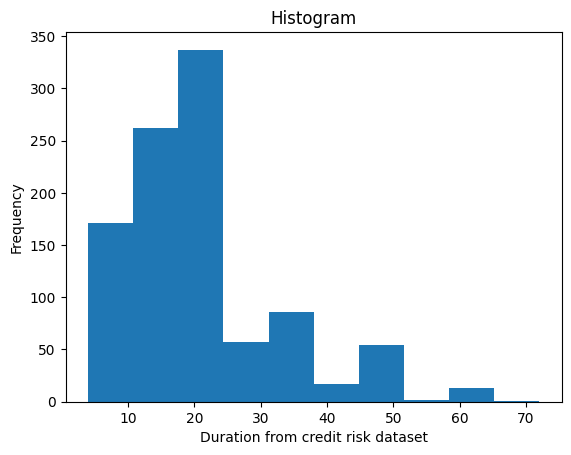

In [ ]:
ax = df['duration'].plot(kind='hist')
ax.set_xlabel("Duration from credit risk dataset")
ax.set_title('Histogram')

In [17]:
category_columns = [
    'checking_account_status', 'credit_history', 'purpose',
    'savings_account_status', 'employment_years', 'personal_status',
    'other_debtors', 'property', 'other_installment_plans', 'housing', 'job']
dataset = pd.get_dummies(df, columns=category_columns, drop_first=True)

# Creating the time and event columns
time_column = 'duration'
event_column = 'full_repaid'

# Creating the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

In [22]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The raw_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The raw_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The raw_dataset contains 0 null values
The raw_dataset contains 0 duplicates


In [23]:
from sklearn.model_selection import train_test_split

to_remove = ['credit_history_existing_credit_paid', 'housing_own']
features = np.setdiff1d(features, to_remove).tolist()
index_train, index_test = train_test_split( range(N), test_size = 0.4)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

## Fit

In [28]:
from gpytorch.models import ApproximateGP # handles basic variational inference
from gpytorch.variational import MeanFieldVariationalDistribution, CholeskyVariationalDistribution # distribution of the approximation q(f)
from gpytorch.variational import VariationalStrategy # use when larger sample - transform q(u) to q(f) over inducing points

class GPModel(ApproximateGP):
    def __init__(self, inducing_points, covariance_type='cholesky'):
        # defines approximation
        if covariance_type == 'cholesky':
          variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        elif covariance_type == 'mean_field':
          variational_distribution = MeanFieldVariationalDistribution(inducing_points.size(0))
        else:
          raise ValueError("Unknown covariance_type.")
        variational_strategy = VariationalStrategy(self, inducing_points,
                                                   variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # defines the GP prior
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        # for line in traceback.format_stack():
        #   print(line.strip())
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [41]:
y.max()

tensor(60.)

In [43]:
mll

VariationalELBO(
  (likelihood): CensoredGaussianLikelihoodAnalytic(
    (noise): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): GPModel(
    (variational_strategy): VariationalStrategy(
      (_variational_distribution): CholeskyVariationalDistribution()
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [47]:
X_train.values.astype(np.float32)

array([[3.5000e+01, 1.4710e+03, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [3.5000e+01, 1.0722e+04, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [5.2000e+01, 6.4680e+03, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        1.0000e+00],
       ...,
       [6.6000e+01, 7.9000e+02, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.1000e+01, 1.9570e+03, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.6000e+01, 1.9250e+03, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]], dtype=float32)

In [56]:
X_train.values.astype(np.float32).shape

(600, 42)

In [60]:
x.std()/lmbd

tensor(158.8951)

In [85]:
del analytical_model, analytical_likelihood

In [117]:
x = torch.FloatTensor(X_train.values.astype(np.float32))
y = torch.FloatTensor(T_train)
MIN_VALUE, MAX_VALUE = y.min(), 72.

censored_model = GPModel(inducing_points=x, covariance_type='cholesky')
censored_likelihood = CensoredGaussianLikelihoodAnalytic(low=MIN_VALUE-1e-6, high=MAX_VALUE+1e-6,
                                                              alpha=1., gamma=1., dzeta=1.)

if torch.cuda.is_available():
    censored_model = censored_model.cuda()
    censored_likelihood = censored_likelihood.cuda()

lmbd = 4 # lmbd in [1,10], 1 -> very linear, 10 -> very non-linear
kappa = 10 # kappa in [2,100], this is the signal to noise ratio. kappa = 2 -> signal = 2*noise
# censored_model.covar_module.base_kernel.initialize(lengthscale=x.std()/lmbd)
censored_model.covar_module.initialize(outputscale=y.var());
censored_model.mean_module.initialize(constant=y.mean())
censored_likelihood.noise.initialize(noise=(y.std()/kappa).square());

censored_model.train()
censored_likelihood.train()
censored_model.train_inputs = (x,)
censored_model.train_targets = y
mll = gpytorch.mlls.VariationalELBO(censored_likelihood, censored_model, num_data=y.size(0))
res = botorch.fit.fit_gpytorch_mll_scipy(mll)
print(res)

OptimizationResult(step=78, fval=3.6336302757263184, status=<OptimizationStatus.SUCCESS: 2>, runtime=36.59468671899958, message='CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH')


In [118]:
domain = torch.FloatTensor(X_test.values.astype(np.float32))
y_test = torch.FloatTensor(T_test)

censored_model.eval()
censored_likelihood.eval()

censored_posterior_f = censored_model(domain)
censored_posterior_y = censored_likelihood(censored_posterior_f)

censored_posterior_y.log_prob(y_test).mean()

tensor(-24.7466, grad_fn=<MeanBackward0>)

In [119]:
import copy
censored_likelihood_replacement = copy.deepcopy(censored_likelihood)

Gaussian

In [120]:
x = torch.FloatTensor(X_train.values.astype(np.float32))
y = torch.FloatTensor(T_train)
MIN_VALUE, MAX_VALUE = y.min(), 72.

uncensored_model = GPModel(inducing_points=x, covariance_type='cholesky')
lmbd = 4 # lmbd in [1,10], 1 -> very linear, 10 -> very non-linear
kappa = 10 # kappa in [2,100], this is the signal to noise ratio. kappa = 2 -> signal = 2*noise
# uncensored_model.covar_module.base_kernel.initialize(lengthscale=x.std()/lmbd)
uncensored_model.covar_module.initialize(outputscale=y.var());
uncensored_model.mean_module.initialize(constant=y.mean())
uncensored_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.NormalPrior(loc=(y.std()/kappa).square(), scale=1))
# uncensored_likelihood.noise.initialize(noise=(y.std()/kappa).square());

if torch.cuda.is_available():
    uncensored_model = uncensored_model.cuda()
    uncensored_likelihood = uncensored_likelihood.cuda()


uncensored_model.train()
uncensored_likelihood.train()
uncensored_model.train_inputs = (x,)
uncensored_model.train_targets = y
mll = gpytorch.mlls.VariationalELBO(uncensored_likelihood, uncensored_model, num_data=y.size(0))
res = botorch.fit.fit_gpytorch_mll_scipy(mll)
print(res)

OptimizationResult(step=28, fval=3.890211820602417, status=<OptimizationStatus.SUCCESS: 2>, runtime=13.648685168000156, message='CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH')


In [121]:
domain = torch.FloatTensor(X_test.values.astype(np.float32))
y_test = torch.FloatTensor(T_test)

uncensored_model.eval()
uncensored_likelihood.eval()

uncensored_posterior_f = uncensored_model(domain)
uncensored_posterior_y = uncensored_likelihood(censored_posterior_f)

uncensored_posterior_y.log_prob(y_test).mean()

tensor(-1595.4829, grad_fn=<MeanBackward0>)

tensor([1.4386], grad_fn=<AddBackward0>) tensor([1.4386], grad_fn=<AddBackward0>) tensor([7.6358], grad_fn=<AddBackward0>)


tensor([1.4386], grad_fn=<AddBackward0>)

In [128]:
censored_likelihood_replacement.noise.noise = uncensored_likelihood.noise
print('Check noise replacement: ',
      uncensored_likelihood.noise.detach().numpy(),
      censored_likelihood_replacement.variance.detach().numpy(),
      censored_likelihood.variance.detach().numpy())

censored_posterior_y = censored_likelihood(censored_posterior_f)
uncensored_posterior_y_diff_lik = censored_likelihood_replacement(uncensored_posterior_f)

print('Censored NLPD: ', -censored_posterior_y.log_prob(y_test).mean())
print('Uncensored NLPD: ', -uncensored_posterior_y_diff_lik.log_prob(y_test).mean())

Check noise replacement:  [1.4455342] [1.4455342] [8.1678295]
Censored NLPD:  tensor(25.0981, grad_fn=<NegBackward0>)
Uncensored NLPD:  tensor(99.7946, grad_fn=<NegBackward0>)


## Survival analysis

In [ ]:
!wget https://github.com/jaredleekatzman/DeepSurv/raw/master/experiments/data/gbsg/gbsg_cancer_train_test.h5

--2024-05-20 11:36:53--  https://github.com/jaredleekatzman/DeepSurv/raw/master/experiments/data/gbsg/gbsg_cancer_train_test.h5
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jaredleekatzman/DeepSurv/master/experiments/data/gbsg/gbsg_cancer_train_test.h5 [following]
--2024-05-20 11:36:54--  https://raw.githubusercontent.com/jaredleekatzman/DeepSurv/master/experiments/data/gbsg/gbsg_cancer_train_test.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86592 (85K) [application/octet-stream]
Saving to: ‘gbsg_cancer_train_test.h5’

gbsg_cancer_train_t 100%[===================>]  84.56K  --.-KB/s    

In [ ]:
pd.read_hdf("gbsg_cancer_train_test.h5")

ValueError: Dataset(s) incompatible with Pandas data types, not table, or no datasets found in HDF5 file.

In [ ]:
import h5py
from collections import defaultdict
datasets = defaultdict(dict)
with h5py.File("gbsg_cancer_train_test.h5", 'r') as fp:
    for ds in fp:
        for array in fp[ds]:
            datasets[ds][array] = fp[ds][array][:]

In [ ]:
{k: v.shape for k,v in datasets['train'].items()}

{'e': (1546,), 't': (1546,), 'x': (1546, 7)}

Text(0.5, 1.0, 'Histogram')

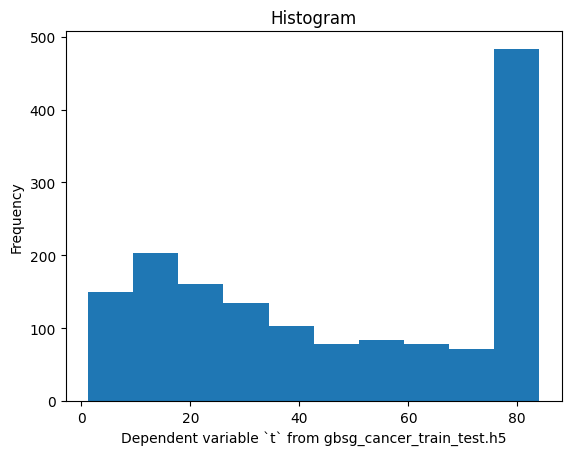

In [ ]:
ax = pd.Series(datasets['train']['t']).plot(kind='hist')
ax.set_xlabel("Dependent variable `t` from gbsg_cancer_train_test.h5")
ax.set_title("Histogram")

Text(0.5, 1.0, 'Histogram')

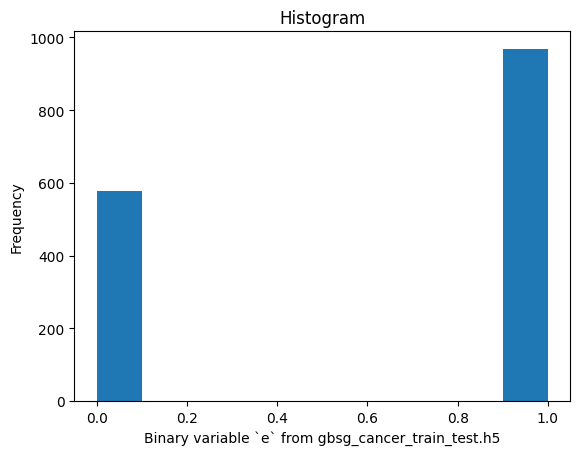

In [ ]:
ax = pd.Series(datasets['train']['e']).plot(kind='hist')
ax.set_xlabel("Binary variable `e` from gbsg_cancer_train_test.h5")
ax.set_title("Histogram")